In [1]:
import os
import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import Tracking_Fatigue as fatigue
import helpers
import importlib
# importlib.reload(tracab)
# importlib.reload(helpers)
# importlib.reload(vis)

from scipy.optimize import curve_fit
from collections import defaultdict

In [750]:
importlib.reload(sns)

<module 'seaborn' from '/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/seaborn/__init__.py'>

# Fatigue model for large dataset

## example read for one player

In [94]:
# EX data
with open('../data_processed/EX_time_series_game_984472.pkl', 'rb') as infile:
    data_dict = pickle.load(infile)

In [95]:
data_dict.keys()

dict_keys(['data_path', 'player_info', 'energy_x', 'ball_in_play'])

In [40]:
players_df.head()

,Match ID,Team,Playerid,Player name,Jersey Num,Starting Position,Starts Match,start_pos_super,first_name,last_name
0,984455,Home,50310,Sebastian Mielitz,28,GK,Start,GK,Sebastian,Mielitz
1,984455,Home,247047,Nicholas Marfelt,18,LFB,Start,FB,Nicholas,Marfelt
2,984455,Home,207273,Stefan Gartenmann,2,RFB,Start,FB,Stefan,Gartenmann
3,984455,Home,56317,Kees Luijckx,5,CD,Start,CB,Kees,Luijckx
4,984455,Home,52560,Marc Pedersen,3,CD,Start,CB,Marc,Pedersen


# Get all games data path

In [91]:
# get paths
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data_processed')
all_data_processed = [os.path.join(data_path, f) for f in os.listdir(data_path)]
game_dicts = {f.split('/')[-1].split('.')[0].split('_')[-1]: f for f in all_data_processed 
              if f.find('.pkl') != -1}

# Fatigue Model

## Fit 2nd degree polynomial on energy expenditure and save

In [85]:
def poly_2nd(x, b, c):
    return 0 + (b * x) + (c * x ** 2)

def plays_full_game(EX_series, thresh=0.95):
    is_full = np.count_nonzero(EX_series)/len(EX_series) > thresh 
    return is_full

In [114]:
coefs = []

# for each game
for match_id, path in game_dicts.items():    
    with open(path, 'rb') as infile:
        data_dict = pickle.load(infile)
    
    # fit model for each game
    for _, player_id, series in data_dict['energy_x']:
        EX_cumul = np.cumsum(series)
        frame_lst = np.array(range(len(EX_cumul)))
        
        # check if is subbed out
        if not plays_full_game(series):
            continue
        
        # fit second degree polynomial that passes through origin
        popt, pcov = curve_fit(poly_2nd, frame_lst, EX_cumul)
        
        # store info
        coefs.append([match_id, player_id, *popt, *np.sqrt(np.diag(pcov))])
        
    print('Done with match {}'.format(match_id))
    
# dataframe of coefficients
df_coefs = pd.DataFrame(coefs, 
                        columns=['match_id', 'player_id', 'b1', 'b2', 'sigma_b1', 'sigma_b2'])
df_coefs.to_csv('../data_model/model_coefs.csv', index=0)

Done with match 984600
Done with match 984601
Done with match 984577
Done with match 984603
Done with match 984617
Done with match 984602
Done with match 984613
Done with match 984565
Done with match 984571
Done with match 984567
Done with match 984605
Done with match 984610
Done with match 984572
Done with match 984566
Done with match 984515
Done with match 984529
Done with match 984514
Done with match 984477
Done with match 984517
Done with match 984473
Done with match 984472
Done with match 984504
Done with match 984510
Done with match 984459
Done with match 984534
Done with match 984497
Done with match 984468
Done with match 984496
Done with match 984535
Done with match 984521
Done with match 984494
Done with match 984457
Done with match 984495
Done with match 984481
Done with match 984532
Done with match 984491
Done with match 984484
Done with match 984527
Done with match 984533
Done with match 984519
Done with match 984492
Done with match 984487
Done with match 984518
Done with m

In [297]:
# re read data
model_data = pd.read_csv(('../data_model/model_coefs.csv'))

## Read in

In [116]:
model_data = pd.read_csv(('../data_model/model_coefs.csv'))

In [164]:
# data distribution
games_per_player = model_data.groupby('player_id').count()['match_id']
game_per_player_data = games_per_player.value_counts().reset_index() 

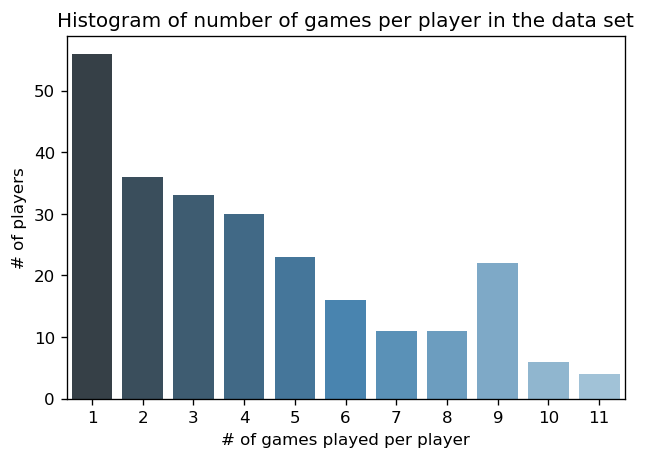

In [849]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
sns.barplot(x='index', y='match_id',
            data=game_per_player_data,
             palette="Blues_d",
           ax=ax)
plt.title('Histogram of number of games per player in the data set')
plt.ylabel('# of players')
plt.xlabel('# of games played per player')
plt.show()

In [261]:
print('# games: ', len(model_data['match_id'].unique()))

# games:  63


## Add position to model data -> `model_data_w_pos`

In [364]:
player_positions = pd.read_csv('../playerid_jerseynum_map.csv')

In [365]:
# add in info 
model_data_w_pos = pd.merge(model_data,
                            player_positions[['Match ID', 'Playerid', 'start_pos_super', 'Starting Position',
                                              'Team', 'Jersey Num', 'first_name', 'last_name']],
                            left_on=['match_id', 'player_id'],
                            right_on=['Match ID', 'Playerid'],
                            how='left').drop(['Match ID', 'Playerid'], axis=1)

In [366]:
model_data_w_pos.head()

,match_id,player_id,b1,b2,sigma_b1,sigma_b2,start_pos_super,Starting Position,Team,Jersey Num,first_name,last_name
0,984600,68250,2.807164,6.748634e-07,0.001069,9.575698e-09,GK,GK,Home,1,Matej,Delac
1,984600,208904,8.995215,-5.770922e-06,0.000853,7.641641e-09,CB,CD,Home,3,Mads,Andersen
2,984600,51656,10.243082,-1.114597e-05,0.001466,1.313169e-08,FB,LFB,Home,5,Michael,Lumb
3,984600,126317,9.749276,-1.292588e-07,0.001870,1.674551e-08,M,CM,Home,6,Sivert,Heltne Nilsen
4,984600,85007,8.067055,-5.418892e-06,0.001702,1.524209e-08,CB,CD,Home,7,Mathias,Nielsen


# New features for regression
## Possession, Time of ball in play

In [367]:
model_data_w_pos['ball_in_play'] = None
model_data_w_pos['possession'] = None

In [370]:
for match_id, path in game_dicts.items():    
    with open(path, 'rb') as infile:
        data_dict = pickle.load(infile)
        
    ball_in_play_data = pd.DataFrame(data_dict['ball_in_play'], columns=['ball_in_play', 'possession'])
    
    # ball in play
    counts_ball = ball_in_play_data['ball_in_play'].value_counts()
    ball_in_play = counts_ball['Alive']  /counts_ball.sum()
    model_data_w_pos.loc[model_data_w_pos['match_id'].astype(int) == int(match_id),
                         'ball_in_play'] = ball_in_play
    
    # possesion
    counts_possession = ball_in_play_data['possession'].value_counts()
    model_data_w_pos.loc[model_data_w_pos['match_id'].astype(str).str.match(str(match_id))
                            & model_data_w_pos['Team'].str.match('Home'),
                        'possession'] = counts_possession['H']/counts_possession.sum()
    model_data_w_pos.loc[model_data_w_pos['match_id'].astype(str).str.match(str(match_id))
                            & model_data_w_pos['Team'].str.match('Away'),
                        'possession'] = counts_possession['A']/counts_possession.sum()
    


## Absolute value of goal difference at 60th minute

In [ ]:
# ???
# hard to know, where are the scores?

## Number of games played in last month

In [378]:
# must read meta data of each game
# get date of each game
# for each player
    # find number of games played in last month

## Save

In [380]:
# save
model_data_w_pos.to_csv('../data_model/model_coefs_processed.csv', index=0)


# Player meta data: Age, height, weight, etc
### Get player features

In [ ]:
# players data
PLAYER_ID_to_JERSEY_NUM_LOC = '../playerid_jerseynum_map.csv'
players_df_raw = pd.read_csv(PLAYER_ID_to_JERSEY_NUM_LOC)

In [284]:
# # read  player data
# danish_player_data = pd.read_csv('../DanishSuperLiga_1819_PlayerData.csv')

# # get player id to name mapping
# name_and_id = players_df[['Playerid', 'Player name', 'first_name', 'last_name']].drop_duplicates()

# # split first and last name
# first_last = danish_player_data['Player'].str.split(expand=True, n=1)
# first_last.columns = ['first_name', 'last_name']
# danish_player_data[['first_name', 'last_name']] = first_last

# # for missing last name, attribute first name
# last_nulls = danish_player_data[danish_player_data['last_name'].isnull()]
# danish_player_data.loc[last_name_nulls_idx, 'last_name'] = danish_player_data.loc[
#     last_name_nulls_idx, 'first_name'
# ]

In [100]:
# # get player id in the player data
# for i, first, last, name in danish_player_data[['first_name', 'last_name', 'Player']].reset_index().values:
#     # last name
#     if last:
#         last_matches = name_and_id['Player name'].str.contains(last)
    
#     # first name
#     if last_matches.any():
#         first_matches = name_and_id[last_matches]['first_name'].str.slice(stop=1).str.contains(first[0])
#         if len(first_matches[first_matches].index) == 1:
#             p_id = name_and_id.loc[first_matches[first_matches].index]['Playerid']
            
#             # set
#             danish_player_data.loc[i, 'player_id'] = p_id.values[0]
#         else:
#             print(len(first_matches[first_matches].index))
            

0
3
2
2
3
3
2
2
2
2
2
3
2
2
0
0
3
3
0
0
0
0
2
0
0
0
2
0
3
0
0
2
0
3
0
0
0
0
0


In [64]:
# write clean data
danish_player_data.to_csv('../DanishSuperLiga_1819_PlayerData_processed.csv', index=0)

# Merge model fit data with player data

In [440]:
# read TWO DATASETS
model_data_processed = pd.read_csv('../data_model/model_coefs_processed.csv')
danish_player_data = pd.read_csv('../DanishSuperLiga_1819_PlayerData_processed.csv')\
                            .drop(['first_name', 'last_name', 'Team', 'Contract expires'], axis=1)

# MERGE
model_and_player_data = pd.merge(model_data_processed.astype({'player_id':float}),
                                 danish_player_data,
                                 on='player_id',
                                 how='left')

In [441]:
model_and_player_data.columns

Index(['match_id', 'player_id', 'b1', 'b2', 'sigma_b1', 'sigma_b2',
       'start_pos_super', 'Starting Position', 'Team', 'Jersey Num',
       'first_name', 'last_name', 'ball_in_play', 'possession', 'Player',
       'Position', 'Age', 'Market value', 'Matches played', 'Minutes played',
       'Goals', 'xG', 'Assists', 'xA', 'Birth country', 'Passport country',
       'Foot', 'Height', 'Weight', 'On loan'],
      dtype='object')

In [442]:
model_and_player_data.head()

,match_id,player_id,b1,b2,sigma_b1,sigma_b2,start_pos_super,Starting Position,Team,Jersey Num,...,Goals,xG,Assists,xA,Birth country,Passport country,Foot,Height,Weight,On loan
0,984600,68250.0,2.807164,6.748634e-07,0.001069,9.575698e-09,GK,GK,Home,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,984600,208904.0,8.995215,-5.770922e-06,0.000853,7.641641e-09,CB,CD,Home,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,984600,51656.0,10.243082,-1.114597e-05,0.001466,1.313169e-08,FB,LFB,Home,5,...,3.0,1.72,2.0,4.40,Denmark,Denmark,left,180.0,79.0,no
3,984600,126317.0,9.749276,-1.292588e-07,0.001870,1.674551e-08,M,CM,Home,6,...,1.0,1.85,0.0,0.96,Norway,Norway,right,184.0,78.0,no
4,984600,85007.0,8.067055,-5.418892e-06,0.001702,1.524209e-08,CB,CD,Home,7,...,0.0,2.08,0.0,0.96,Denmark,Denmark,right,187.0,80.0,no


## Delete 25% of data with null rows 

In [443]:
# number of player data missing
display(model_and_player_data['Age'].isnull().value_counts())

False    786
True     242
Name: Age, dtype: int64

In [444]:
model_and_player_data = model_and_player_data.dropna()

## Data set visualizations

In [465]:
share_by_pos = model_and_player_data.groupby('start_pos_super').count()['player_id']

In [850]:
# fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
# ax.pie(share_by_pos,labels=share_by_pos.index,
#        autopct='%1.1f%%', textprops=dict(color="w"))
# ax.set_title('Distribution of data points per position')
# plt.legend()

# # plt.legend()
# plt.show()

## Export final dataset

In [1236]:
model_and_player_data.to_csv('./dataset_final.csv', index=0)

# Read data

In [2]:
model_and_player_data = pd.read_csv('./dataset_final.csv')

In [3]:
# get rid of unecessary columns
positions_idx = model_and_player_data['start_pos_super']
data = model_and_player_data[
    ['b1', 'b2', 'sigma_b1', 'sigma_b2',
     'Height', 'Weight', 'Age', 'ball_in_play', 'possession',
     'Matches played', 'Minutes played', 'start_pos_super',
       'Goals', 'xG', 'Assists', 'xA']
]

# only selected features
data = data[
        ['b1', 'b2', 'sigma_b1', 'sigma_b2','start_pos_super',
     'Height', 'Weight', 'Age', 'ball_in_play', 'possession']
    
]

In [4]:
mapping = dict(zip(['FB', 'M', 'CB', 'F', 'GK'], range(1, 6)))

In [5]:
# discretize
data.loc[:, 'start_pos_super'] = data['start_pos_super'].apply(lambda x: mapping[x])
data = data.rename({'start_pos_super':'position'}, axis=1)

# Standardize

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [8]:
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

,b1,b2,sigma_b1,sigma_b2,position,Height,Weight,Age,ball_in_play,possession
0,-0.107345,-0.295573,-0.338208,-0.343493,-1.457342,-0.700358,0.109486,1.117553,-0.7792,-0.485828
1,-0.283248,0.949500,0.216214,0.209711,-0.621356,-0.027427,-0.013765,0.122043,-0.7792,-0.485828
2,-0.882484,0.351683,-0.014436,-0.020432,0.214631,0.477271,0.232737,0.370920,-0.7792,-0.485828
3,-0.783903,0.680501,-0.350787,-0.356045,1.050617,0.477271,-0.013765,-0.873468,-0.7792,-0.485828
4,-0.632478,1.154792,-0.570414,-0.575189,1.050617,-1.036824,-0.260266,-0.375712,-0.7792,-0.485828


# Final processing

In [9]:
# labels Y
Y = data_scaled[['b1', 'b2']]

In [10]:
# feature X
features = ['position', 'Age', 'Height', 'Weight', 'ball_in_play', 'possession']

X = data_scaled[features]

# Feature selection

In [11]:
ax

NameError: name 'ax' is not defined

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(7, 7), dpi=150)
cor = data_scaled.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f', color='b')
ax.set_ylim(len(cor), 0)
plt.title('Heatmap of Pearson correlation ')
plt.show()

In [12]:
results1

NameError: name 'results1' is not defined

In [1357]:
results

array([-0.00446365,  0.17931471,  0.17928669])

In [18]:
X.loc[:, 'constant'] = 1

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
X = X.drop('constant', )

# one model for all

In [19]:
X.keys()

Index(['position', 'Age', 'Height', 'Weight', 'ball_in_play', 'possession',
       'constant'],
      dtype='object')

In [43]:
# models
lasso, ridge, osl = linear_model.Lasso(), linear_model.Ridge(), linear_model.LinearRegression()

# evaluate
lasso_r2, ridge_r2, osl_r2 = [cross_val_score(model, X, Y, 
                                              cv=5, scoring='r2') 
                              for model in [lasso, ridge, osl]]

print(np.array([lasso_r2, ridge_r2, osl_r2]))
results = np.array([lasso_r2, ridge_r2, osl_r2]).mean(axis=1)
print(results)

[[-0.00216616 -0.00752989 -0.00218055 -0.00883407 -0.0016076 ]
 [ 0.23658493  0.22999451  0.16871625  0.13029097  0.13098689]
 [ 0.23661167  0.23003168  0.16870244  0.1301772   0.13091048]]
[-0.00446365  0.17931471  0.17928669]


In [44]:
lasso, ridge, osl = linear_model.Lasso(), linear_model.Ridge(), linear_model.LinearRegression()


In [34]:
osl.intercept_ = 2

# sklearn Regression
One regression per position

In [15]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
import sklearn
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, r2_score

In [38]:
# indices of positions
pos_to_idx = positions_idx.reset_index().groupby('start_pos_super')['index'].apply(list)

In [39]:
# one model per position
scores = []

for pos, indices in pos_to_idx.to_dict().items():
    print(pos)
    X_pos = X.loc[indices]
    Y_pos = Y.loc[indices]
    X_train, X_test, Y_train, Y_test = train_test_split(X_pos, Y_pos, 
                                                        test_size=0.3, random_state=1)
    # regression sklearn
    lasso, ridge, osl = linear_model.Lasso(), linear_model.Ridge(), linear_model.LinearRegression()
    lasso.fit(X_train, Y_train)
    ridge.fit(X_train, Y_train)
    osl.fit(X_train, Y_train)
    print('R^2 score: ', lasso.score(X_test, Y_test))
    print('R^2 score: ', ridge.score(X_test, Y_test))
    print('R^2 score: ', osl.score(X_test, Y_test))
    
    # regression stats model
#      statsmodels.multivariate.multivariate_ols._MultivariateOLS

    # predict and score
#     preds = reg.predict(X_test)
#     print('R^2 score: ', r2_score(Y_test, preds))
    
#     # MSE
#     print('MSE score: ', mean_squared_error(Y_test, preds))
    
    # evaluate
    lasso_r2, ridge_r2, osl_r2 = [cross_val_score(model, X_pos, Y_pos, cv=5, scoring='r2') 
                                  for model in [lasso, ridge, osl]]
    
    # coefficient
    print('Coefficients: ',[mod.coef_ for mod in [lasso, ridge, osl]])

    # save regressor
    scores.append([pos, np.mean(lasso_r2), np.mean(ridge_r2), np.mean(osl_r2)])

    print()

CB
R^2 score:  -0.0007394195589048751
R^2 score:  -0.015456705610699475
R^2 score:  -0.015994692244178665
Coefficients:  [array([[ 0., -0., -0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0.,  0.,  0.]]), array([[ 4.19960623e-31, -1.09951734e-01, -1.51042398e-01,
         3.02230701e-02,  2.72203013e-04, -4.72473302e-02,
         0.00000000e+00],
       [ 3.26238313e-32,  7.45200120e-02, -7.27620474e-02,
         1.69038177e-01, -3.14271759e-02,  6.25094951e-02,
         0.00000000e+00]]), array([[ 0.        , -0.11136456, -0.15545194,  0.03469755, -0.00050991,
        -0.04726418,  0.        ],
       [ 0.        ,  0.07395496, -0.07786589,  0.17531961, -0.03228052,
         0.06308495,  0.        ]])]

F
R^2 score:  -0.018113952398404243
R^2 score:  0.12246919727877571
R^2 score:  0.11882638324316334
Coefficients:  [array([[ 0., -0.,  0., -0.,  0., -0.,  0.],
       [-0.,  0., -0.,  0., -0.,  0.,  0.]]), array([[ 7.83827295e-31, -2.96511227e-01,  9.80998743e-02,
        -6.571

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the 

Coefficients:  [array([[ 0., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -0., -0., -0.,  0.,  0.]]), array([[ 5.65585224e-31, -1.11928927e-01,  7.00232028e-02,
         3.68891217e-01,  8.99967490e-02, -4.67036468e-03,
         0.00000000e+00],
       [-1.46775951e-31,  3.92847048e-02, -5.04208338e-02,
        -3.36832241e-01, -7.65032524e-02,  6.29077100e-02,
         0.00000000e+00]]), array([[ 0.        , -0.11389587,  0.0628439 ,  0.3963001 ,  0.09332315,
        -0.00603773,  0.        ],
       [ 0.        ,  0.04053193, -0.04361438, -0.36214015, -0.07961788,
         0.06479491,  0.        ]])]

GK
R^2 score:  -0.004776951486091239
R^2 score:  -0.10260326335205676
R^2 score:  -0.11416911934739532
Coefficients:  [array([[-0., -0., -0., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0., -0.,  0.]]), array([[-3.67595713e-30, -4.60618063e-03,  7.51365747e-02,
        -2.36127886e-01,  3.98053181e-02,  4.06550717e-02,
         0.00000000e+00],
       [ 5.64918888e-31,  9.2465

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the 

In [40]:
scores

[['CB', -0.008761689732249178, -0.04183103442454881, -0.04274559624149106],
 ['F', -0.03687686555398821, 0.1495733916062028, 0.14590688580326705],
 ['FB', -0.023941023136370365, -0.040681482514656545, -0.04355190049120553],
 ['GK', -0.11168230593991195, -0.22571965815860748, -0.2390058526318529],
 ['M', -0.037927071123725266, -0.03896094622597547, -0.039185470388598945]]

In [41]:
# scores displayed
selected = pd.DataFrame(scores, columns=['position', 'R2_lasso', 'R2_ridge', 'R2_OSL']).set_index('position')

In [42]:
selected

,R2_lasso,R2_ridge,R2_OSL
position,,,
CB,-0.008762,-0.041831,-0.042746
F,-0.036877,0.149573,0.145907
FB,-0.023941,-0.040681,-0.043552
GK,-0.111682,-0.225720,-0.239006
M,-0.037927,-0.038961,-0.039185


In [1312]:
without_age

,R2_lasso,R2_ridge,R2_OSL
position,,,
CB,-0.008762,-0.051291,-0.052215
F,-0.036877,0.067798,0.065387
FB,-0.023941,-0.054668,-0.057555
GK,-0.111682,-0.198709,-0.218685
M,-0.037927,-0.060966,-0.061172


In [1181]:
X_pos

,ball_in_play,possession
1,-0.779200,-0.485828
6,-0.779200,-0.485828
7,-0.779200,0.502417
15,0.295576,-1.129934
20,0.295576,1.146524
...,...,...
767,0.611808,0.719621
768,1.823694,-0.449149
773,1.823694,-0.449149
774,1.823694,0.465738


# Random forest for feature selection

In [1119]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [1234]:
# Create a random forest classifier
sel = SelectFromModel(RandomForestRegressor())
sel.fit(X_train, Y_train)


feature_selec = list(zip(X_train.keys().tolist(), sel.get_support()))

pd.DataFrame(feature_selec, columns=['position', 'selected']).set_index('position')

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,selected
position,
ball_in_play,False
possession,True


In [1235]:
sel

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators='warn',
                                                n_jobs=None, oob_score=False,
                                                random_state=None, verbose=0,
                                                warm_start=False),
                max_features=None, norm_order=1, prefit=False,

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


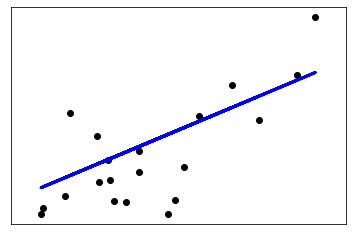

In [1125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()